## Find the 15 nearest turbines to the first turbine based on their UTM coordinates using the Nearest Neighbors algorithm.

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# ================================
# Step 1: read settlement and filter turbines
# ================================
settlement = pd.read_parquet("energinet/settlement/2019.parquet")

# convert VAERDI to numeric, coerce errors to NaN
settlement["VAERDI"] = pd.to_numeric(settlement["VAERDI"], errors="coerce")

# compute mean power per GSRN and filter those with mean > 0
mean_power_per_gsrn = settlement.groupby("GSRN")["VAERDI"].mean()
valid_gsrns = set(mean_power_per_gsrn[mean_power_per_gsrn > 0].index)

# ================================
# Step 2: read masterdatawind and filter turbines
# ================================
df = pd.read_parquet("energinet/masterdatawind.parquet")

# keep only W-type turbines with valid UTM coordinates and in valid_gsrns
df = df[
    (df["Turbine_type"] == "W") &
    (df["UTM_x"].notnull()) &
    (df["UTM_y"].notnull()) &
    (df["GSRN"].isin(valid_gsrns))
].copy()

# drop duplicates, keep the earliest In_service date
df = df.sort_values("In_service").drop_duplicates(subset="GSRN", keep="first")

# ================================
# Step 3: Nearest Neighbors selection
# ================================
coords = df[["UTM_x", "UTM_y"]].values
model = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(coords)
_, indices = model.kneighbors([coords[0]])

# select the 15 turbines
selected = df.iloc[indices[0]].copy()

# ================================
# Step 4: output results
# ================================
print("Selected 15 W-type turbines with non-zero generation in 2019:")
print(selected[["GSRN", "Turbine_name", "UTM_x", "UTM_y", "Capacity_kw", "In_service"]])

# save to CSV
selected.to_csv("selected_15_turbines_filtered.csv", index=False)

Selected 15 W-type turbines with non-zero generation in 2019:
                     GSRN                            Turbine_name      UTM_x  \
85087  571313174116253585              Frederiksborgvej 399, 4000  694932.00   
10617  570714700000106958                   Forskningscenter Risø  694694.00   
1747   570714700000004575                   Forskningscenter Risø  694665.00   
1776   570714700000004605                  Klaus Hartmann Nielsen  697337.00   
1740   570714700000004568                  Kongemarkens Vindmølle  689965.00   
2126   570714700000005213                                Darupvej  693240.77   
1895   570714700000004810             Jens Frellsen Trællerupgård  686396.00   
1956   570714700000004964                               Ole Olsen  702955.00   
1719   570714700000004513                         Flemming Jensen  694942.00   
70172  570715000000107078                                    IKEA  706543.00   
10562  570714700000106699                  Bramsnæs Vindmø

## Visualize selected 15 turbines

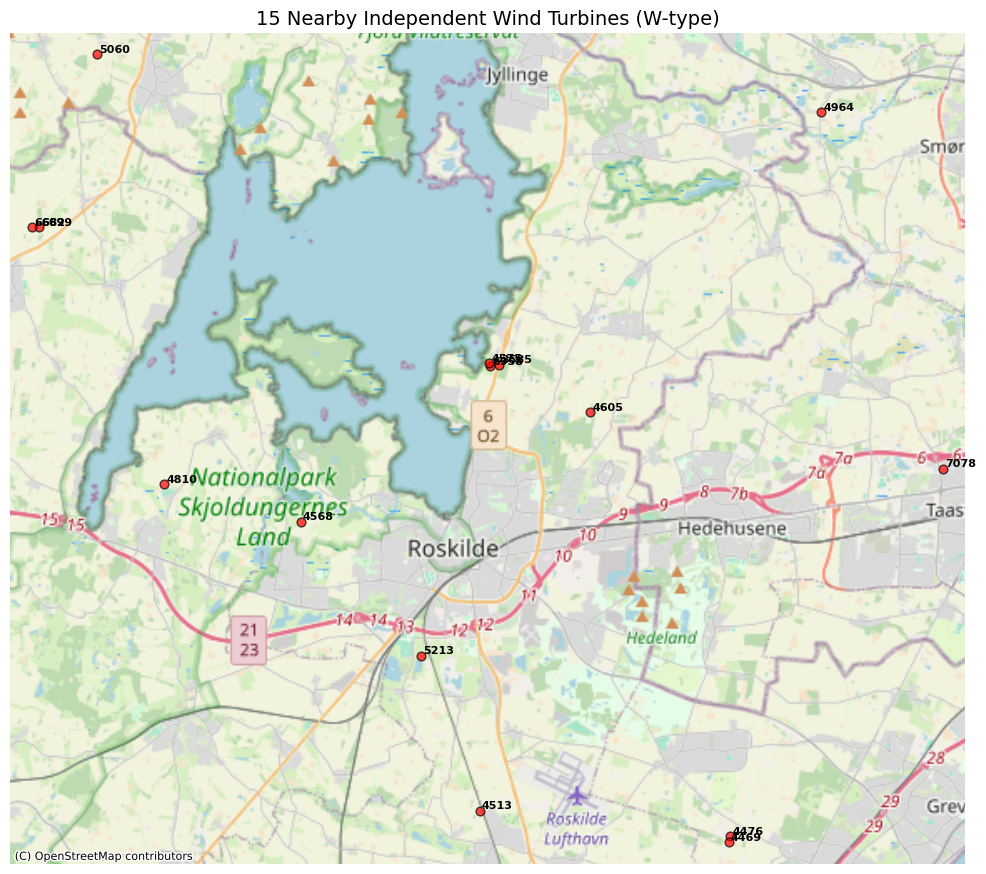

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# create a GeoDataFrame from selected turbines
selected_gdf = gpd.GeoDataFrame(
    selected,
    geometry=gpd.points_from_xy(selected["UTM_x"], selected["UTM_y"]),
    crs="EPSG:25832"
)

# transform to Web Mercator for plotting with contextily
selected_gdf = selected_gdf.to_crs(epsg=3857)

# draw
fig, ax = plt.subplots(figsize=(10, 10))

# draw points for turbines
selected_gdf.plot(ax=ax, color='red', markersize=40, edgecolor='black', alpha=0.7)

# add labels with last 4 digits of GSRN on the map
for idx, row in selected_gdf.iterrows():
    gsrn_suffix = str(row["GSRN"])[-4:]
    ax.text(row.geometry.x + 100, row.geometry.y + 100, gsrn_suffix,
            fontsize=8, color='black', weight='bold')

# set auto limits with some padding in the map view
ax.set_xlim(selected_gdf.total_bounds[0] - 1000, selected_gdf.total_bounds[2] + 1000)
ax.set_ylim(selected_gdf.total_bounds[1] - 1000, selected_gdf.total_bounds[3] + 1000)

# add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# finalize plot by removing axes and adding title
plt.axis("off")
plt.title("15 Nearby Independent Wind Turbines (W-type)", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

settlement = pd.read_parquet("energinet/settlement2/Year=2019")
print(settlement.columns)

Index(['GSRN', 'TS_ID', 'VAERDI', 'TIME_CET'], dtype='object')


In [ ]:
# load selected turbines
selected_gsrns = selected["GSRN"].unique()

# load settlement data
df_settle = pd.read_parquet("energinet/settlement/2019.parquet")
matched_gsrns = df_settle["GSRN"].unique()

# find missing and existing GSRNs
missing_gsrns = set(selected_gsrns) - set(matched_gsrns)
existing_gsrns = set(selected_gsrns) & set(matched_gsrns)

# print results
print("GSRNs with data in settlement file:", sorted(existing_gsrns))
print("GSRNs missing from settlement file:", sorted(missing_gsrns))

GSRNs with data in settlement file: ['570714700000004469', '570714700000004476', '570714700000004513', '570714700000004568', '570714700000004575', '570714700000004605', '570714700000004810', '570714700000004964', '570714700000005060', '570714700000005213', '570714700000106682', '570714700000106699', '570714700000106958', '570715000000107078', '571313174116253585']
GSRNs missing from settlement file: []


## Extracted statistical features (mean, std, CV, zero ratio, ramp stats) from 15 turbines’ 2019 power data and applied normalization for further analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------- STEP 1: read selected turbines ----------
selected_gsrns = selected["GSRN"].tolist()

# ---------- STEP 2: read settlement and filter turbines ----------
settlement = pd.read_parquet("energinet/settlement/2019.parquet")
df_settle = settlement[settlement["GSRN"].isin(selected_gsrns)].copy()

# ---------- STEP 3: parse time fields ----------
df_settle["timestamp"] = pd.to_datetime(df_settle["TIME_CET"])
df_settle["hour"] = df_settle["timestamp"].dt.hour
df_settle["date"] = df_settle["timestamp"].dt.date

# ---------- STEP 4: feature engineering ----------
feature_list = []

for gsrn, group in df_settle.groupby("GSRN"):
    power = pd.to_numeric(group["VAERDI"], errors="coerce")  # transform to numeric, set errors to NaN
    mean_power = power.mean()
    std_power = power.std()
    cv = std_power / mean_power if mean_power else None
    zero_ratio = (power == 0).mean()
    ramp_rate = power.diff()
    ramp_mean = ramp_rate.mean()
    ramp_std = ramp_rate.std()

    feature_list.append({
        "GSRN": gsrn,
        "mean_power": mean_power,
        "std_power": std_power,
        "cv": cv,
        "zero_ratio": zero_ratio,
        "ramp_mean": ramp_mean,
        "ramp_std": ramp_std,
    })

features_df = pd.DataFrame(feature_list)

# ---------- STEP 5: feature scaling ----------
# select columns to scale (excluding GSRN and zero_ratio)
columns_to_scale = ["mean_power", "std_power", "cv", "ramp_mean", "ramp_std"]

scaler = StandardScaler()
scaled_values = scaler.fit_transform(features_df[columns_to_scale])

# create a DataFrame for scaled values
scaled_df = pd.DataFrame(scaled_values, columns=[f"{col}_scaled" for col in columns_to_scale])
scaled_df["GSRN"] = features_df["GSRN"]

# combine original and scaled data
features_df = features_df.merge(scaled_df, on="GSRN")

# ---------- STEP 6: output results and save to CSV ----------
pd.set_option("display.precision", 4)
print(features_df)

features_df.to_csv("features_in_group_stage.csv", index=False)

                  GSRN  mean_power  std_power       cv  zero_ratio  \
0   570714700000004469      5.0354    19.3422   3.8413      0.8865   
1   570714700000004476      0.0497     1.2910  25.9982      0.9979   
2   570714700000004513     76.7097   104.3009   1.3597      0.1820   
3   570714700000004568      7.9155    23.9728   3.0286      0.8370   
4   570714700000004575     25.0780    67.3957   2.6874      0.7048   
5   570714700000004605    131.1473   164.2375   1.2523      0.2246   
6   570714700000004810     26.0019    36.3505   1.3980      0.2374   
7   570714700000004964      2.1657     5.3510   2.4708      0.4337   
8   570714700000005060      5.2400     7.9871   1.5242      0.2303   
9   570714700000005213     97.7856   122.2415   1.2501      0.2191   
10  570714700000106682    155.4123   194.9810   1.2546      0.1259   
11  570714700000106699    147.5727   192.7004   1.3058      0.1475   
12  570714700000106958     34.4187    48.3852   1.4058      0.2174   
13  5707150000001070

In [56]:
import pandas as pd

wind_speed = pd.read_parquet("energinet/prognosis/ENetNEA/wind_speed_100m.parquet")
print(wind_speed.columns)

Index(['190', '191', '231', '232', '233', '273', '274', '275', '314', '315',
       ...
       '1412', '1413', '1445', '1446', '1447', '1448', '1449', '1450', '1451',
       'predicted_ahead'],
      dtype='object', length=355)


## Extracted power curve features per turbine:
### (1) Residual MSE by wind speed bins,
### (2) average hourly power profile, and
### (3) first 5 Fourier components of the daily profile.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ---------- Step 0: get selected turbines ----------
selected["GSRN"] = selected["GSRN"].astype(str)
selected_gsrns = selected["GSRN"].tolist()
capacity_map = dict(zip(selected["GSRN"], selected["Capacity_kw"]))

# ---------- Step 1: load power generation data ----------
settlement = pd.read_parquet("energinet/settlement/2019.parquet")
settlement["timestamp"] = pd.to_datetime(settlement["TIME_CET"])
settlement["VAERDI"] = pd.to_numeric(settlement["VAERDI"], errors="coerce")
settlement["GSRN"] = settlement["GSRN"].astype(str)
settlement = settlement[settlement["GSRN"].isin(selected_gsrns)].copy()

# normalize VAERDI by Capacity_kw
settlement["Capacity_kw"] = settlement["GSRN"].map(capacity_map)
settlement["VAERDI_norm"] = settlement["VAERDI"] / settlement["Capacity_kw"]

# ---------- Step 2: load wind speed data and flatten ----------
raw_wind = pd.read_parquet("energinet/prognosis/ENetNEA/wind_speed_100m.parquet")
wind_long = raw_wind.drop(columns=["predicted_ahead"]).copy()
wind_long = wind_long.melt(var_name="offset_hour", value_name="wind_speed")
wind_long["offset_hour"] = pd.to_numeric(wind_long["offset_hour"], errors="coerce")
base_time = pd.Timestamp("2019-01-01 00:00:00")
wind_long["timestamp"] = base_time + pd.to_timedelta(wind_long["offset_hour"], unit="h")
avg_wind = wind_long.groupby("timestamp")["wind_speed"].mean().reset_index()

# ---------- Step 3: merge two data sources ----------
merged = pd.merge(
    settlement[["GSRN", "timestamp", "VAERDI_norm"]],
    avg_wind,
    on="timestamp",
    how="inner"
).dropna()

# ---------- Step 4: extract features for each turbine ----------
results = []

for gsrn, group in merged.groupby("GSRN"):
    group = group.sort_values("timestamp").copy()

    # Feature 1: Residual MSE by Wind Speed bin
    group["wind_bin"] = pd.cut(group["wind_speed"], bins=np.arange(0, 26, 2))
    residuals = []

    for _, bin_df in group.groupby("wind_bin", observed=True):
        if len(bin_df) >= 5:
            x = bin_df[["wind_speed"]]
            y = bin_df["VAERDI_norm"]
            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            mse = mean_squared_error(y, y_pred)
            residuals.append(mse)

    residual_mse = np.mean(residuals) if residuals else np.nan

    # Feature 2: Daily Power Curve
    group["hour"] = group["timestamp"].dt.hour
    hourly_mean = group.groupby("hour")["VAERDI_norm"].mean().reindex(range(24), fill_value=np.nan)
    daily_profile = hourly_mean.values

    # Feature 3: Fourier components
    fourier_coeffs = np.fft.fft(daily_profile)
    fourier_features = np.abs(fourier_coeffs[:5])

    results.append({
        "GSRN": gsrn,
        "residual_mse": residual_mse,
        **{f"hour_{i}": v for i, v in enumerate(daily_profile)},
        **{f"fft_{i}": v for i, v in enumerate(fourier_features)}
    })

# ---------- Step 5: output results and save to CSV ----------
features_df = pd.DataFrame(results)
pd.set_option("display.precision", 4)
print(features_df.head())

features_df.to_csv("power_curve_features_in_group_stage.csv", index=False)

                 GSRN  residual_mse  hour_0  hour_1  hour_2  hour_3  hour_4  \
0  570714700000004469        0.0040  0.0025  0.0006  0.0376  0.0267  0.0287   
1  570714700000004476        0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2  570714700000004513        0.0253  0.1277  0.1252  0.1497  0.1512  0.1406   
3  570714700000004568        0.0117  0.0642  0.0402  0.0754  0.0594  0.0310   
4  570714700000004575        0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

   hour_5  hour_6  hour_7  ...  hour_19  hour_20  hour_21  hour_22  hour_23  \
0  0.0369  0.0000  0.0000  ...   0.0169   0.0372   0.0291   0.0440   0.0506   
1  0.0000  0.0000  0.0000  ...   0.0000   0.0000   0.0000   0.0000   0.0000   
2  0.1683  0.1378  0.1339  ...   0.0979   0.1296   0.1587   0.1919   0.1407   
3  0.0255  0.0121  0.0120  ...   0.0602   0.0413   0.0801   0.0859   0.0369   
4  0.0000  0.0000  0.0000  ...   0.0000   0.0000   0.0000   0.0000   0.0000   

   fft_0   fft_1   fft_2   fft_3   fft_4  
0  0.33

## Normalized Daily Power Curve of 15 Wind Turbines

/var/folders/rx/y63trwp10b9dm1lbhqqv7_rw0000gn/T/ipykernel_76421/173990369.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(selected_gsrns))


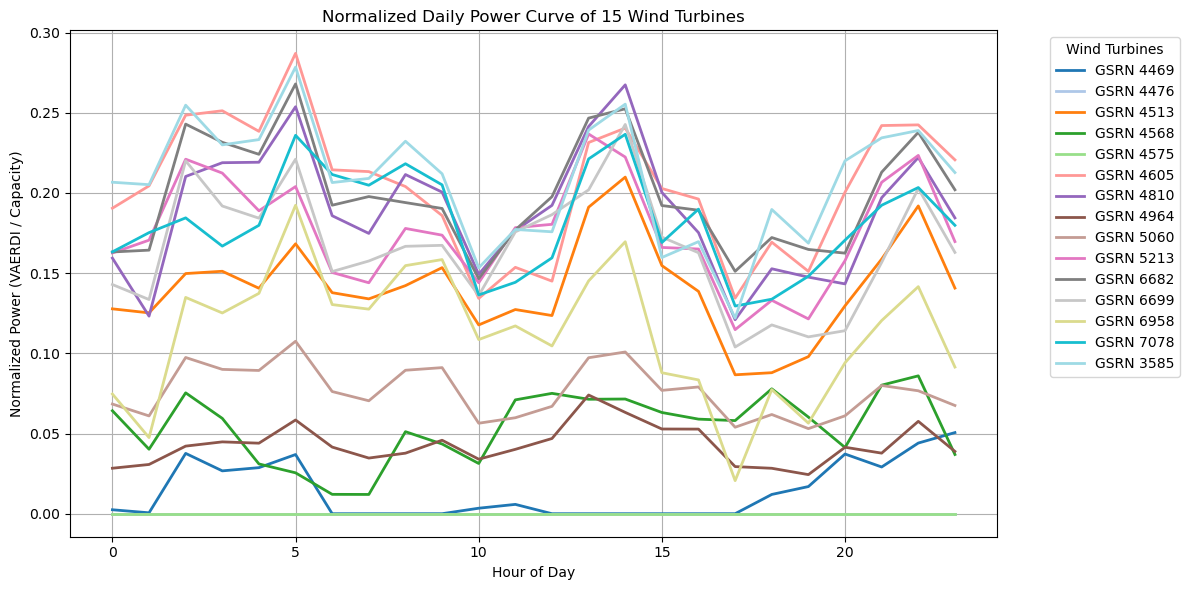

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# extract GSRN list 
selected_gsrns = selected["GSRN"].astype(str).tolist()
features_df = features_df[features_df["GSRN"].isin(selected_gsrns)].copy()

# create a color mapping (tab20 has 20 distinct colors)
cmap = cm.get_cmap('tab20', len(selected_gsrns))
colors = [cmap(i) for i in range(len(selected_gsrns))]

# draw plot
plt.figure(figsize=(12, 6))

for i, (_, row) in enumerate(features_df.iterrows()):
    hours = list(range(24))
    values = [row[f"hour_{h}"] for h in hours]
    gsrn_suffix = str(row["GSRN"])[-4:]
    plt.plot(hours, values, label=f"GSRN {gsrn_suffix}", color=colors[i], linewidth=2)

plt.title("Normalized Daily Power Curve of 15 Wind Turbines")
plt.xlabel("Hour of Day")
plt.ylabel("Normalized Power (VAERDI / Capacity)")
plt.legend(title="Wind Turbines", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Residual MSE of 15 Wind Turbines (after capacity normalization)

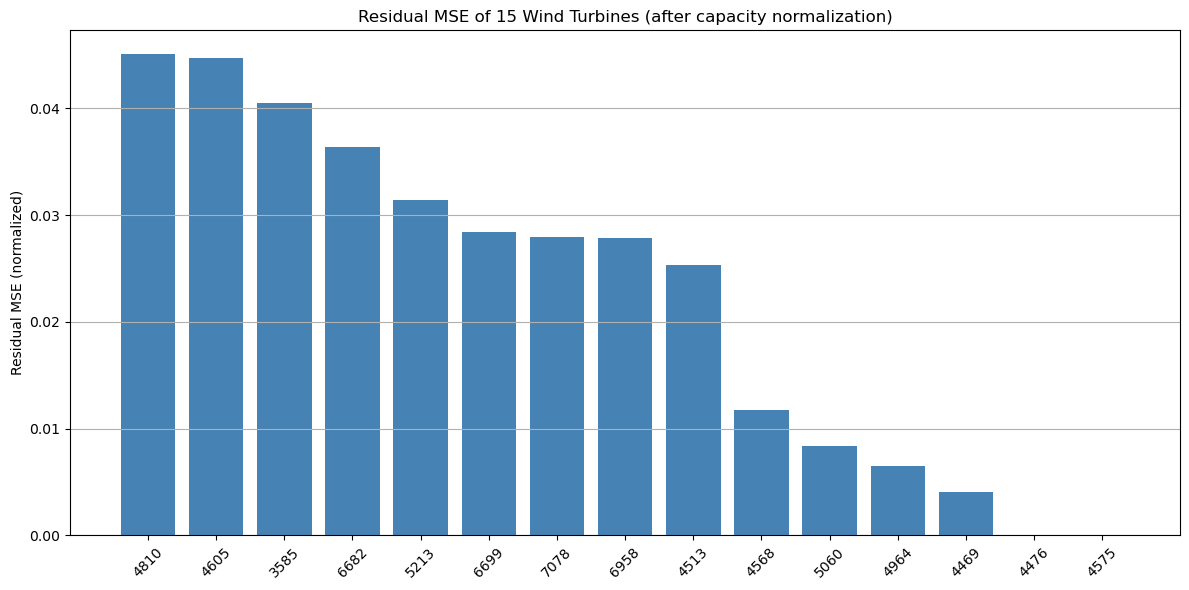

In [ ]:
import matplotlib.pyplot as plt

# order by residual_mse descending
features_sorted = features_df.sort_values("residual_mse", ascending=False)

# draw bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    features_sorted["GSRN"].astype(str).str[-4:],  # 只显示 GSRN 后4位
    features_sorted["residual_mse"],
    color="steelblue"
)
plt.xticks(rotation=45)
plt.ylabel("Residual MSE (normalized)")
plt.title("Residual MSE of 15 Wind Turbines (after capacity normalization)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()